### Import Libraries and Define Functions

In [4]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import time

In [5]:
#define plotting style that I like
style.use('fivethirtyeight')

#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

In [6]:
###########################################################################################################
### Functions for general utility and computing necessary basic equations
###########################################################################################################
#define runtime calculator
def timer(elapsed_time):
    seconds = (time.time() - elapsed_time)
    day = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    seconds = seconds
    print('')
    print('Total cell runtime:', "%s days, %s hours, %s minutes, %s seconds" % ('%.0f'%day, '%.0f'%hour, '%.0f'%minutes, '%.4f'%seconds) )
    print('')
    
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)

def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

###########################################################################################################
### Functions for combining datasets 
###########################################################################################################
def new_phenom_rename(df, observable):
    df.rename(columns={'t_lab':'energy'}, inplace=True)
    df.rename(columns={'observable':'experimental_value'}, inplace=True)
    df.rename(columns={'error':'sigma'}, inplace=True)
    df['observable']=observable
    
def combine_data_exp_only():
    ###create combined dataframe
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([exp_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def combine_data_phenom_only():
    ###create combined dataframe
    #old phenomenological data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #new phenomenological data
    sgt_small= pd.read_csv('CSV_files/sgt_0_75.csv')
    sgtt_small=pd.read_csv('CSV_files/sgtt_0_75.csv')
    sgt_large=pd.read_csv('CSV_files/sgt_75_350.csv')
    sgtt_large=pd.read_csv('CSV_files/sgtt_75_350.csv')
    new_phenom_rename(sgt_small,'   SGT ')
    new_phenom_rename(sgtt_small,'   SGTT')
    new_phenom_rename(sgt_large,'   SGT ')
    new_phenom_rename(sgtt_large,'   SGTT')
    new_data = pd.concat([sgt_small, sgt_large, sgtt_small, sgtt_large])
    #combine
    combined_data = pd.concat([random_data, new_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def combine_data_total():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #new phenomenological data
    sgt_small= pd.read_csv('CSV_files/sgt_0_75.csv')
    sgtt_small=pd.read_csv('CSV_files/sgtt_0_75.csv')
    sgt_large=pd.read_csv('CSV_files/sgt_75_350.csv')
    sgtt_large=pd.read_csv('CSV_files/sgtt_75_350.csv')
    new_phenom_rename(sgt_small,'   SGT ')
    new_phenom_rename(sgtt_small,'   SGTT')
    new_phenom_rename(sgt_large,'   SGT ')
    new_phenom_rename(sgtt_large,'   SGTT')
    new_data = pd.concat([sgt_small, sgt_large, sgtt_small, sgtt_large])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data, new_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def gauss_factor(combined_data, mu, sigma):
    ###create Gaussian factor 
    #Gaussian distribution
    combined_data['Gauss_factor'] = np.random.normal(mu, sigma, len(combined_data.energy))
    combined_data['Gauss_exp'] = combined_data.apply(lambda row: ((row.K_experimental_value) + (row.K_sigma*row.Gauss_factor)), axis=1)
    #remove unecessary columns
    combined_data = combined_data.drop(columns=['K_experimental_value', 'K_sigma', 'experimental_value', 'k', 'sigma', 'Gauss_factor'])
    return combined_data

###########################################################################################################
### Functions for complex math, training, and plotting results
###########################################################################################################
def train_and_plot(rxn_observable, reac_observ):
    #start timer
    rxn_observable_time = time.time()
    # One-hot encode categorical features
    rxn_observable_plot = pd.get_dummies(rxn_observable)
    # Labels are the values we want to predict
    labels = np.array(rxn_observable_plot['K_experimental_value'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features = rxn_observable_plot.drop('K_experimental_value', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    rxn_observable_test_mean=np.zeros(intervals) 
    rxn_observable_train_mean=np.zeros(intervals) 
    rxn_observable_test_variance=np.zeros(intervals) 
    rxn_observable_train_variance=np.zeros(intervals) 
    for i in range(intervals): 
        #define size
        size=(i+1)/(intervals+1)
        #call split function
        test, test_v, train, train_v = split_and_score(size, number_of_random_states)
        #add to arrays
        rxn_observable_test_mean[i]=test
        rxn_observable_train_mean[i]=train
        rxn_observable_test_variance[i]=test_v
        rxn_observable_train_variance[i]=train_v
    print("Average Testing Score:", rxn_observable_test_mean)
    print('Testing Variance', rxn_observable_test_variance)
    print('')
    print('Average Training Score', rxn_observable_train_mean)
    print('Training Variance', rxn_observable_train_variance)
    print('')

    #plot 

    #figure
    figure(figsize=(15, 5))
    ax=plt.subplot(111)
    plt.xlabel('Test Size (%)')
    plt.ylabel('Score')
    plt.title("Reaction_Observable: {}".format(reac_observ))
    plt.xlim(left=0, right=100)
    ax.scatter(sample_size, rxn_observable_test_mean, s=100, label='Average Testing Score')
    ax.scatter(sample_size, rxn_observable_train_mean, s=100, label='Average Training Score')
    ax.errorbar(sample_size, rxn_observable_test_mean, yerr=rxn_observable_test_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.errorbar(sample_size, rxn_observable_train_mean, yerr=rxn_observable_train_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.legend(loc='best')
    plt.show

    #print elapsed time
    timer(rxn_observable_time)
    
def plot_training_data(np_sgt, np_sgtt, point_label_string, file_path_string):
    E_sgt=np_sgt['energy']
    exp_sgt=np_sgt['K_experimental_value']
    err_sgt=np_sgt['K_sigma']
    E_sgtt=np_sgtt['energy']
    exp_sgtt=np_sgtt['K_experimental_value']
    err_sgtt=np_sgtt['K_sigma']
    
    
    #plot
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
    fig.autofmt_xdate(rotation = 45)
    fig.suptitle(''+point_label_string+'', fontsize=40, fontweight='bold')

    ###plot 1
    ax1.scatter(E_sgt, exp_sgt, alpha=0.5, label=point_label_string)
    ax1.errorbar(E_sgt, exp_sgt, yerr=err_sgt, linestyle='none', capsize=5, elinewidth=2, alpha=0.5)

    ax1.set_xlim([-10,360])
    ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
    ax1.set_xlabel('Energy (MeV)', fontsize=15); ax1.set_ylabel('K * Experimental Value', fontsize=15)
    ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)
    
    ###plot 2
    ax2.scatter(E_sgtt, exp_sgtt, alpha=0.5, label=point_label_string)
    ax2.errorbar(E_sgtt, exp_sgtt, yerr=err_sgtt, linestyle='none', capsize=5, elinewidth=2, alpha=0.5)

    ax2.set_xlim([-10,360])
    ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
    ax2.set_xlabel('Energy (MeV)', fontsize=15); ax2.set_ylabel('K * Experimental Value', fontsize=15)
    ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)
    
    #save figures
    plt.savefig(file_path_string, format='pdf', bboxinches='tight', transparent=True)
    

def plot_gauss_preds(combine_method, file_path_string, data_type_string):
    #start timer
    gauss_time=time.time()

    #define interval specifications for prediction arrays
    E_max=350
    num_intervals = E_max/interval_size
    E_index = list(range(interval_size, E_max + int(interval_size), interval_size)) ###this will be index of dataframe

    df_SGT=pd.DataFrame({'Energy': E_index})
    df_SGTT=pd.DataFrame({'Energy': E_index})


    for n in range(1,n_max+1):
        ###create combined dataframe
        combined_data=combine_method()
        ###create Gaussian factor 
        combined_data=gauss_factor(combined_data, 0, 1)

        ###train
        #One-hot encode
        features = pd.get_dummies(combined_data)
        # Labels are the values we want to predict
        labels = np.array(features['Gauss_exp'])
        # Remove the labels from the features
        features = features.drop('Gauss_exp', axis = 1)
        # Saving feature names for later use
        feature_list = list(features.columns)
        # Convert to numpy array
        features = np.array(features)
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_data_size)
        rf = RandomForestRegressor(n_estimators= num_trees)
        # Train the model on training data
        rf.fit(train_features, train_labels);

        ###make predictions 
        #construct testing arrays
        E_SGT = []
        E_SGTT = []
        E = list(range(interval_size, E_max + int(interval_size), interval_size))
        for value in E:
            E_SGT.append([value, 1, 0])
            E_SGTT.append([value, 0, 1])
        #predict
        #SGT
        SGT_predictions = rf.predict(E_SGT)
        #SGTT
        SGTT_predictions = rf.predict(E_SGTT)

        #add column to dataframes
        df_SGT["SGT_Preds_%s"%('%.0f'%n)] = SGT_predictions
        df_SGTT["SGTT_Preds_%s"%('%.0f'%n)] = SGTT_predictions

        #print completed message
        if (n_max <= 14):
            print("Predictions computed with n = %s "%(n))
        elif (n_max > 14) and (n_max <= 49): 
            if (n%5 == 0):
                print('Predictions computed with n = %s - %s' %(int(n-4), n) )
        elif (n_max > 49) and (n_max <=99): 
            if (n%10 == 0):
                print('Predictions computed with n = %s - %s' %(int(n-9), n) )
        elif (n_max > 99): 
            if (n%25 == 0):
                print('Predictions computed with n = %s - %s' %(int(n-24), n) )
        if (n==n_max):
            print("")
            print("Calculations using "+data_type_string+" for training are complete.")
            print("Predictions computed with %s iterations." %(n) )

    #predictions array     
    df_SGT = df_SGT.drop("Energy", axis=1)
    df_SGT['Prediction Mean'] = df_SGT.mean(axis=1)
    df_SGT['Prediction Variance'] = df_SGT.var(axis=1)
    df_SGTT = df_SGTT.drop("Energy", axis=1)
    df_SGTT['Prediction Mean'] = df_SGTT.mean(axis=1)
    df_SGTT['Prediction Variance'] = df_SGTT.var(axis=1)

    #plot 
    #figure specs
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
    fig.autofmt_xdate(rotation = 45)
    fig.suptitle('Predictions', fontsize=40, fontweight='bold')



    #plot 1 - SGT
    ax1.scatter(E, df_SGT['Prediction Mean'], label='Predictions')
    ax1.errorbar(E, df_SGT['Prediction Mean'], yerr=df_SGT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2)

    ax1.tick_params(axis="y", labelsize=20)
    ax1.tick_params(axis="x", labelsize=20)
    #ax1.legend(loc='best', fontsize=20)
    ax1.set_xlabel('Energy (MeV)', fontsize=25)
    ax1.set_xlim([-10,360])
    ax1.set_ylim(bottom=0)
    ax1.set_ylabel('K * Experimental Value', fontsize=25)
    ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)


    ax1.text(0.0, 0.95, "%s Iterations Completed"% (n_max), fontsize=30, transform=plt.gcf().transFigure)
    ax1.text(0.0, 0.92, "%s Decision Trees Used"% (num_trees), fontsize=30, transform=plt.gcf().transFigure)
    ax1.text(0.7, 0.95, "Trained With:", fontsize=30, transform=plt.gcf().transFigure)
    ax1.text(0.7, 0.92, data_type_string, fontsize=30, transform=plt.gcf().transFigure)

    #plot 2 - SGTT
    ax2.scatter(E, df_SGTT['Prediction Mean'], label='Predictions')
    ax2.errorbar(E, df_SGTT['Prediction Mean'], yerr=df_SGTT['Prediction Variance'], linestyle='none', capsize=5, elinewidth=2)

    ax2.tick_params(axis="y", labelsize=20)
    ax2.tick_params(axis="x", labelsize=20)
    #ax2.legend(loc='best', fontsize=20)
    ax2.set_xlabel('Energy (MeV)', fontsize=25)
    ax2.set_xlim([-10,360])
    ax2.set_ylabel('K * Experimental Value', fontsize=25)
    ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)

    #save figures
    plt.savefig(file_path_string, format='pdf', bboxinches='tight', transparent=True)

    #print elapsed time
    timer(gauss_time)

### Raw Data Prep and Plot

In [7]:
#organize experimental and phenomenological data for plotting
#read files
exp_sgt=pd.read_csv('CSV_files/np.sgt.csv')
exp_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
random_sgt=pd.read_csv('CSV_files/random.sgt.csv')
random_sgtt=pd.read_csv('CSV_files/random.sgtt.csv')
sgt_small= pd.read_csv('CSV_files/sgt_0_75.csv')
sgtt_small=pd.read_csv('CSV_files/sgtt_0_75.csv')
sgt_large=pd.read_csv('CSV_files/sgt_75_350.csv')
sgtt_large=pd.read_csv('CSV_files/sgtt_75_350.csv')
#edits to columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
new_phenom_rename(sgt_small,'   SGT ')
new_phenom_rename(sgtt_small,'   SGTT')
new_phenom_rename(sgt_large,'   SGT ')
new_phenom_rename(sgtt_large,'   SGTT')
#combine phenom data
phenom_sgt = pd.concat([sgt_small, sgt_large, random_sgt], sort=True)
phenom_sgtt = pd.concat([sgtt_small, sgtt_large, random_sgtt], sort=True)
#add k columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
exp_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
exp_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(exp_sgt)
change_np(exp_sgtt)
change_np(phenom_sgt)
change_np(phenom_sgtt)
#drop uneccesary columns
exp_sgt = exp_sgt.drop(columns=['scattering_angle', 'reaction_type', 'systematic_error', 'normalization'])
exp_sgtt = exp_sgtt.drop(columns=['scattering_angle', 'reaction_type', 'systematic_error', 'normalization'])
phenom_sgt = phenom_sgt.drop(columns=['reaction_type', 'k'])
phenom_sgtt = phenom_sgtt.drop(columns=['reaction_type', 'k'])
#make combined dataframes
total_sgt = pd.concat([phenom_sgt, exp_sgt], sort=True)
total_sgtt = pd.concat([phenom_sgtt, exp_sgtt], sort=True)

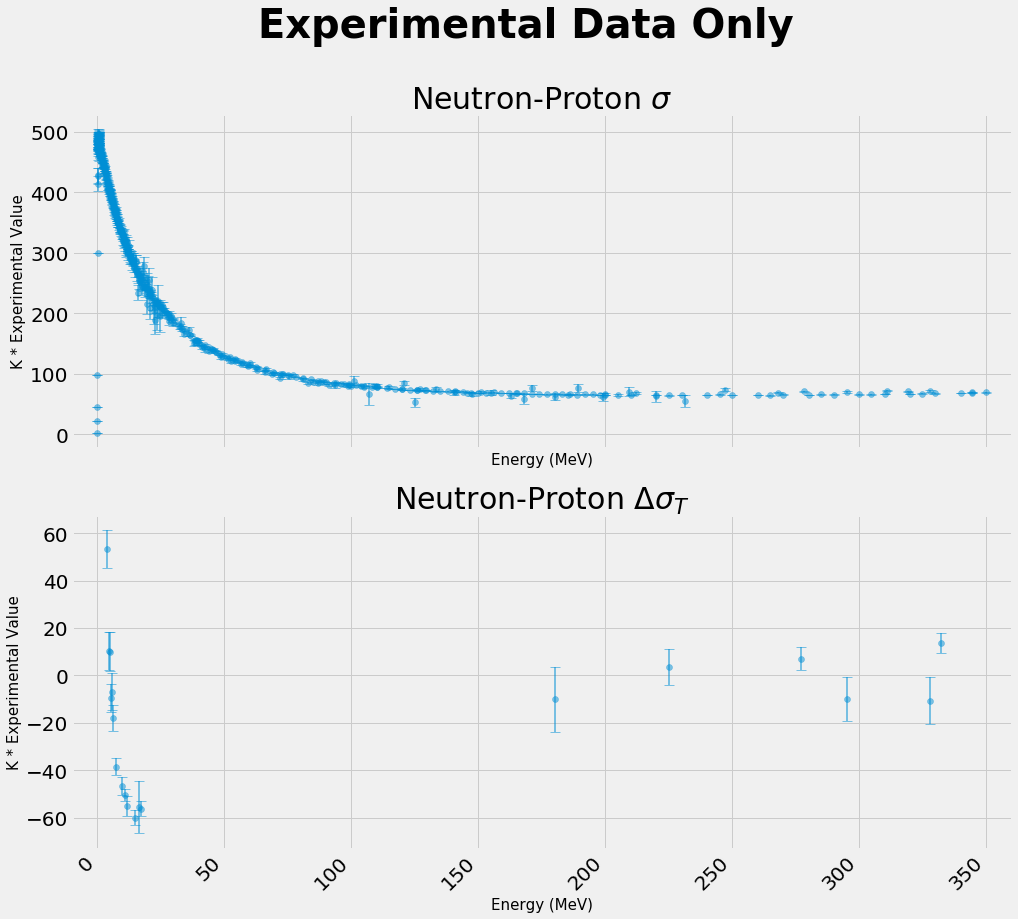

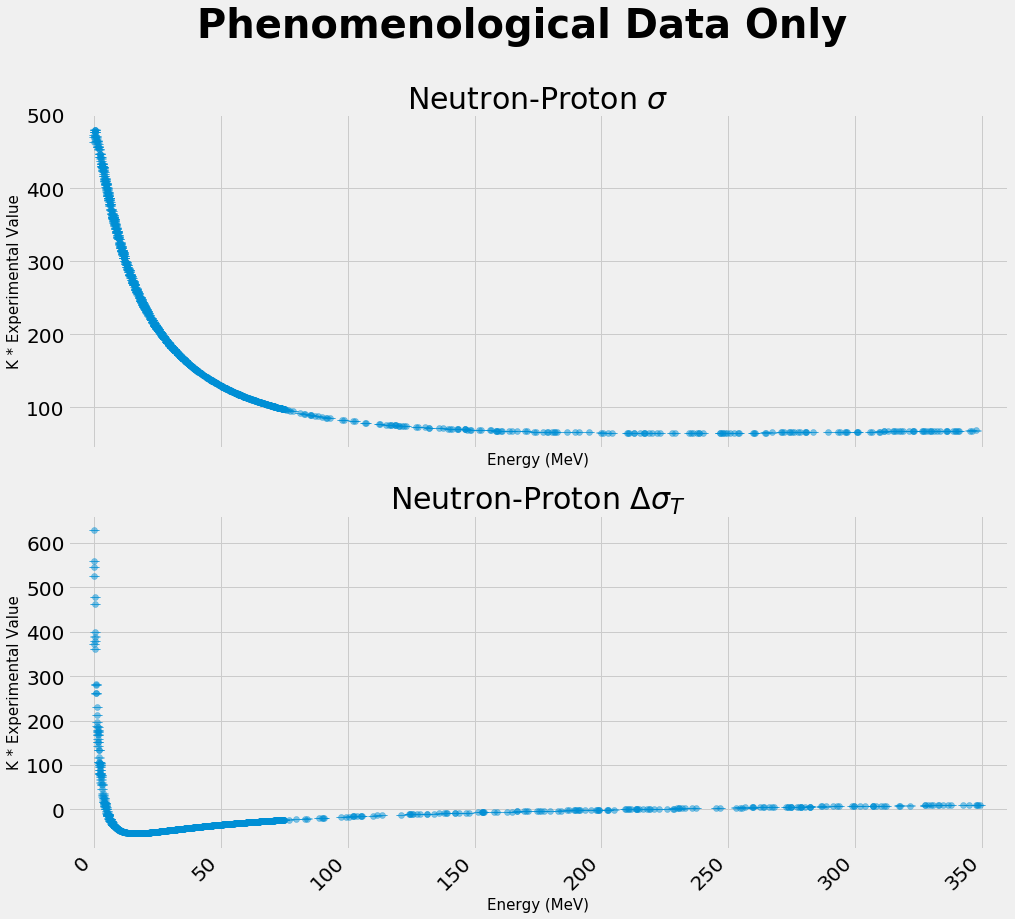

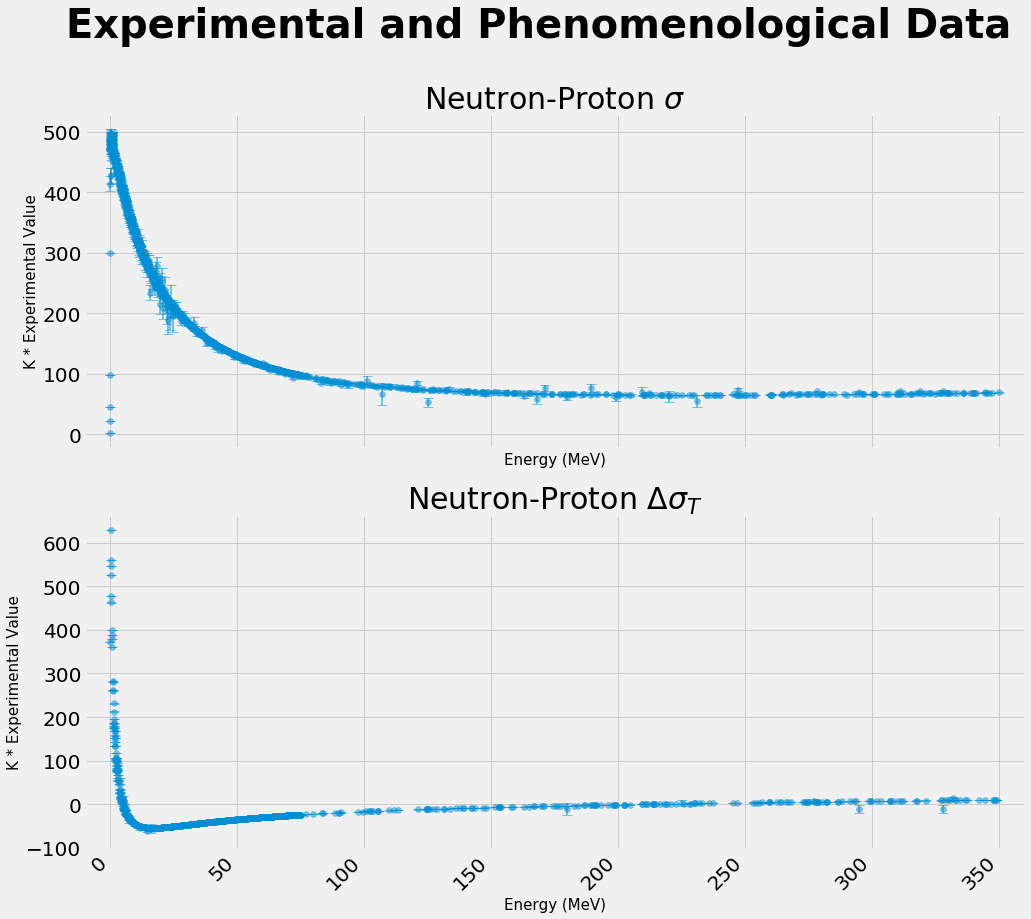

In [8]:
plot_training_data(exp_sgt, exp_sgtt, "Experimental Data Only", "Plots/Presentation_Plots/raw_experimental_data_only.pdf")

plot_training_data(phenom_sgt, phenom_sgtt, "Phenomenological Data Only", "Plots/Presentation_Plots/raw_phenomenological_data_only.pdf")

plot_training_data(total_sgt, total_sgtt, "Experimental and Phenomenological Data", "Plots/Presentation_Plots/raw_experimental_and_phenomenological_data.pdf")

### Gaussian Predictions

In [9]:
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
###  PARAMETERS TO BE CHANGED ARE ALL IN THIS CELL  ###
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################

#define number of times to make predictions with different gaussian factor
n_max=50

#define interval step size for predictions 
###MUST BE INTEGER >=1 AND FACTOR OF 350
interval_size = 5 #MeV  

#define number of trees used in random forest 
num_trees=2500

#define test size
test_data_size = 0.25 # % of total amount of data

Predictions computed with n = 1 - 10
Predictions computed with n = 11 - 20
Predictions computed with n = 21 - 30
Predictions computed with n = 31 - 40
Predictions computed with n = 41 - 50

Calculations using Exp Data Only for training are complete.
Predictions computed with 50 iterations.

Total cell runtime: 0 days, 0 hours, 2 minutes, 14.5511 seconds



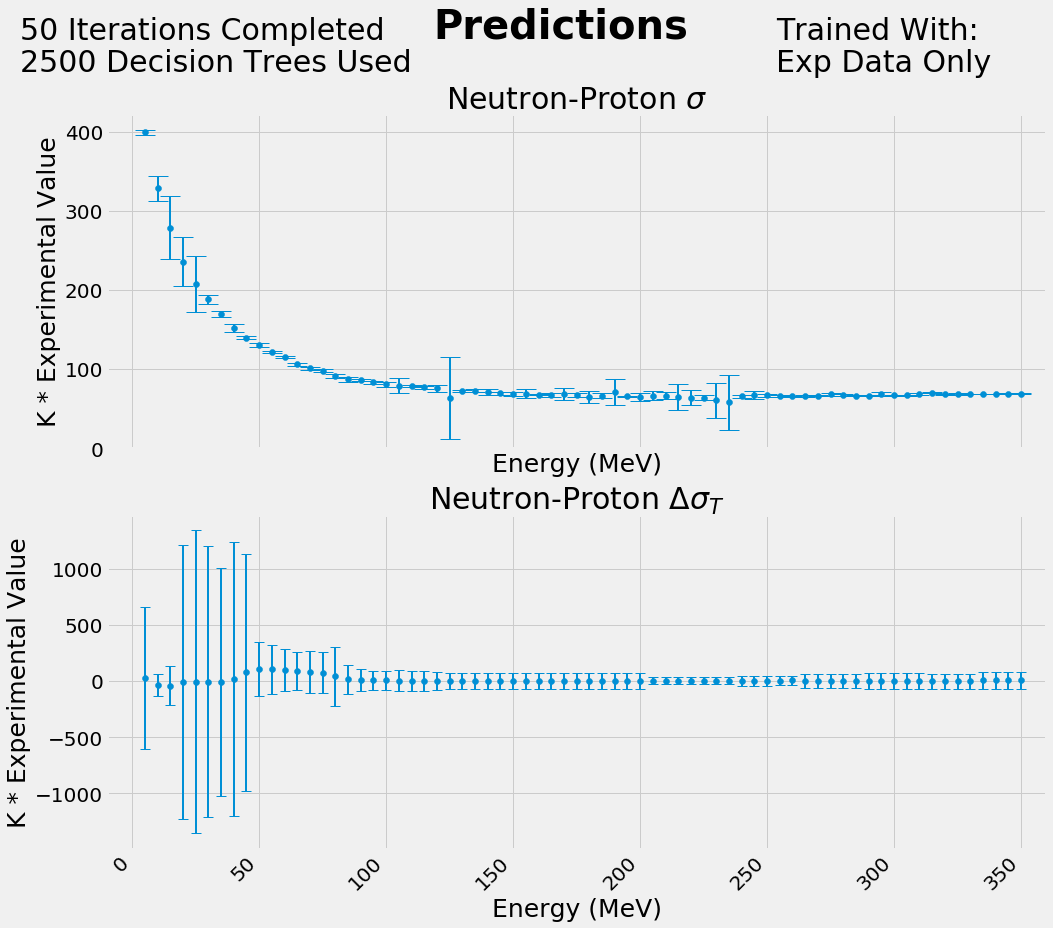

In [10]:
plot_gauss_preds(combine_data_exp_only, "Plots/Presentation_Plots/predictions_experimental_data_only.pdf", 
                "Exp Data Only")

Predictions computed with n = 1 - 10
Predictions computed with n = 11 - 20
Predictions computed with n = 21 - 30
Predictions computed with n = 31 - 40
Predictions computed with n = 41 - 50

Calculations using Phenom Data Only for training are complete.
Predictions computed with 50 iterations.

Total cell runtime: 0 days, 0 hours, 6 minutes, 0.3898 seconds



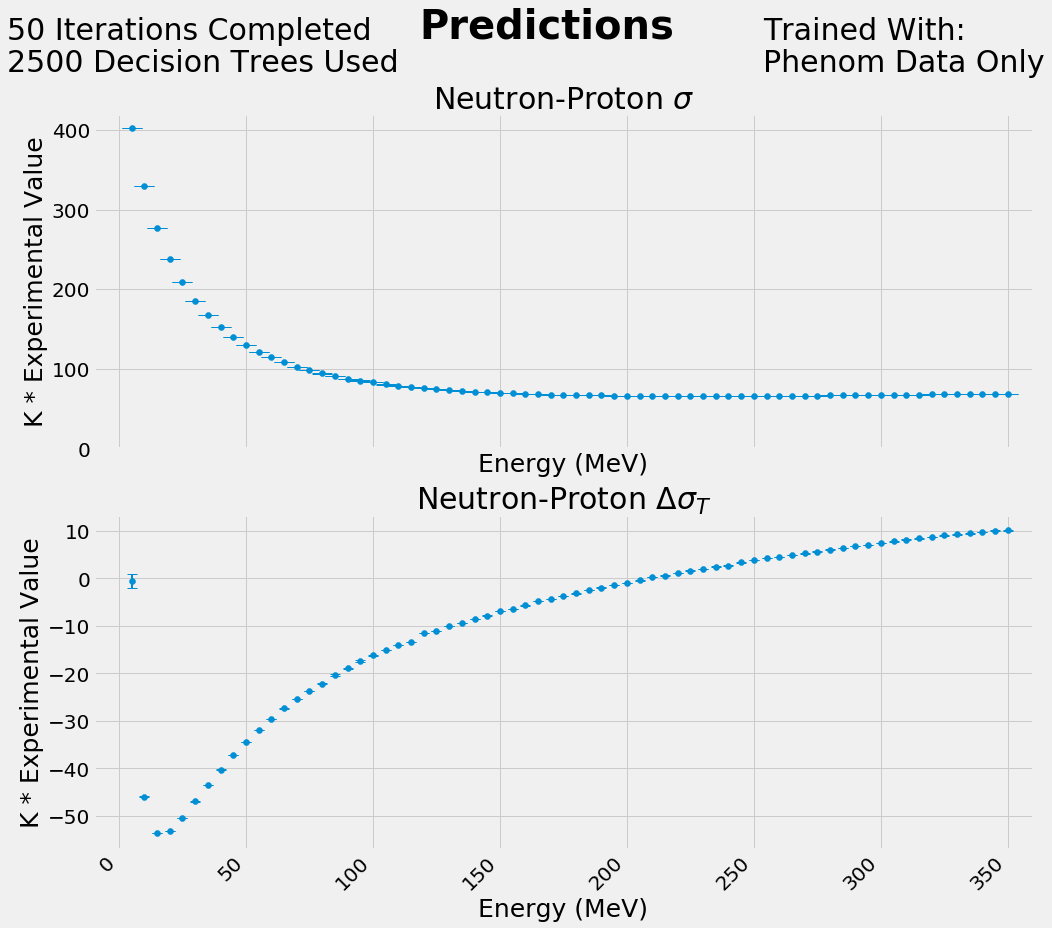

In [11]:
plot_gauss_preds(combine_data_phenom_only, "Plots/Presentation_Plots/predictions_phenomenological_data_only.pdf",
                "Phenom Data Only")

In [ ]:
plot_gauss_preds(combine_data_total, "Plots/Presentation_Plots/predictions_experimental_and_phenomenological_data.pdf",
                "Exp and Phenom Data")

Predictions computed with n = 1 - 10
Predictions computed with n = 11 - 20


In [ ]:
#start timer
gauss_time=time.time()

#define interval specifications for prediction arrays
E_max=350
num_intervals = E_max/interval_size
E_index = list(range(interval_size, E_max + int(interval_size), interval_size)) ###this will be index of dataframe

df_SGT=pd.DataFrame({'Energy': E_index})
df_SGTT=pd.DataFrame({'Energy': E_index})


for n in range(1,n_max+1):
    ###create combined dataframe
    combined_data=combine_data_new()
    #combined_data=combine_data_old()
    ###create Gaussian factor 
    combined_data=gauss_factor(combined_data, 0, 1)

    ###train
    #One-hot encode
    features = pd.get_dummies(combined_data)
    # Labels are the values we want to predict
    labels = np.array(features['Gauss_exp'])
    # Remove the labels from the features
    features = features.drop('Gauss_exp', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_data_size)
    rf = RandomForestRegressor(n_estimators= num_trees)
    # Train the model on training data
    rf.fit(train_features, train_labels);

    ###make predictions 
    #construct testing arrays
    E_SGT = []
    E_SGTT = []
    E = list(range(interval_size, E_max + int(interval_size), interval_size))
    for value in E:
        E_SGT.append([value, 1, 0])
        E_SGTT.append([value, 0, 1])
    #predict
    #SGT
    SGT_predictions = rf.predict(E_SGT)
    #SGTT
    SGTT_predictions = rf.predict(E_SGTT)
    
    #add column to dataframes
    df_SGT["SGT_Preds_%s"%('%.0f'%n)] = SGT_predictions
    df_SGTT["SGTT_Preds_%s"%('%.0f'%n)] = SGTT_predictions
    
    #print completed message
    if (n_max <= 14):
        print("Predictions computed with n = %s "%(n))
    elif (n_max > 14) and (n_max <= 49): 
        if (n%5 == 0):
            print('Predictions computed with n = %s - %s' %(int(n-4), n) )
    elif (n_max > 49) and (n_max <=99): 
        if (n%10 == 0):
            print('Predictions computed with n = %s - %s' %(int(n-9), n) )
    elif (n_max > 99): 
        if (n%25 == 0):
            print('Predictions computed with n = %s - %s' %(int(n-24), n) )
    if (n==n_max):
        print("")
        print("Calculations complete.")
        print("Predictions computed with %s iterations." %(n) )

#predictions array     
df_SGT = df_SGT.drop("Energy", axis=1)
df_SGT['Prediction Mean'] = df_SGT.mean(axis=1)
df_SGT['Prediction Variance'] = df_SGT.var(axis=1)
df_SGTT = df_SGTT.drop("Energy", axis=1)
df_SGTT['Prediction Mean'] = df_SGTT.mean(axis=1)
df_SGTT['Prediction Variance'] = df_SGTT.var(axis=1)

#plot 
#figure specs
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)
fig.suptitle('Predictions', fontsize=40, fontweight='bold')



#plot 1 - SGT
ax1.scatter(E, df_SGT['Prediction Mean'], label='Mean of Predictions')
ax1.errorbar(E, df_SGT['Prediction Mean'], yerr=df_SGT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')

ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=25)
ax1.set_xlim([-10,360])
ax1.set_ylim(bottom=0)
ax1.set_ylabel('K * Experimental Value', fontsize=25)
ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)


ax1.text(0.1, 0.55, "%s Iterations Completed"% (n_max), fontsize=20, transform=plt.gcf().transFigure)
ax1.text(0.1, 0.52, "%s Decision Trees Used"% (num_trees), fontsize=20, transform=plt.gcf().transFigure)

#plot 2 - SGTT
ax2.scatter(E, df_SGTT['Prediction Mean'], label='Mean of Predictions')
ax2.errorbar(E, df_SGTT['Prediction Mean'], yerr=df_SGTT['Prediction Variance'], linestyle='none', capsize=5, elinewidth=2, label='Variance of Predictions')

ax2.tick_params(axis="y", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=25)
ax2.set_xlim([-10,360])
ax2.set_ylabel('K * Experimental Value', fontsize=25)
ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)

#save figures
plt.savefig('Plots/predictions_with_gauss.pdf', format='pdf', bboxinches='tight', transparent=True)

#print elapsed time
timer(gauss_time)

In [ ]:
df_SGT['Energy']=E
df_SGT.set_index("Energy", inplace = True)
df_SGT

In [ ]:
df_SGTT['Energy']=E
df_SGTT.set_index("Energy", inplace = True)
df_SGTT